# Credit Card Fraud Detection

In [1]:
# Importing Libraries
import pandas as pd
import pickle
import json
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Reading training data
card_details_train = pd.read_csv('fraudTrain.csv', index_col=0)

In [3]:
card_details_train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


### Data Analysis
Checking for null values and unnecessary columns

In [4]:
# Checking if the data is null
card_details_train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

<Axes: >

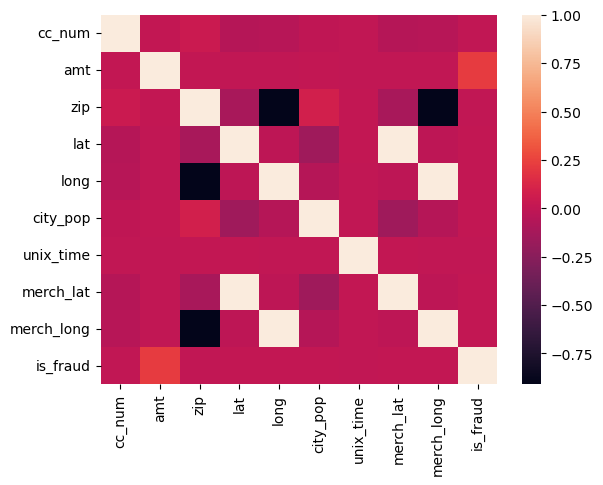

In [5]:
sb.heatmap(card_details_train[[i for i in card_details_train.columns\
                         if card_details_train[i].dtype in ['int64', 'int32', 'float64', 'float32']]]\
                            .corr())

In [6]:
metadata = {'category':card_details_train['category'].unique().tolist(), 'job':card_details_train.job.unique().tolist()}
with open('D:/Programming/metadata.json', 'w') as f:
    json.dump(metadata, f)

### Data Cleaning and Feature Engineering

In [7]:
# Classifying time into morning/afternoon/evening/night
def convertTime(df):
    if df['trans_date_trans_time'] > 6 and df['trans_date_trans_time'] < 12:
        return 0
    elif df['trans_date_trans_time'] > 12 and df['trans_date_trans_time'] < 18:
        return 1
    elif df['trans_date_trans_time'] > 18 and df['trans_date_trans_time'] < 24:
        return 2
    else:
        return 3

encoder = TargetEncoder(cols=['category', 'job'])
def preprocess_data(data, state, encoder):
    # Dropping unnecessary columns
    data.drop(['city_pop','state','city','street','trans_num','long','lat','merch_long','merch_lat','last','first','unix_time','zip','merchant','cc_num'], axis = 1, inplace=True)

    # Encoding categorical data
    le = LabelEncoder()
    data['gender'] = le.fit_transform(data['gender'])
    
    # Using target encoding as number of categories/jobs were huge
    if(state == 0):
        encoder.fit(data.iloc[:,:-1], data.iloc[:,-1])
    transformed_data = encoder.transform(data.iloc[:,:-1], data.iloc[:,-1])
    data = pd.concat([transformed_data, data['is_fraud']], axis = 1)
    
    # Extracting age
    data['dob'] = pd.to_datetime(data['dob'])
    age = datetime.now().year - data['dob'].dt.year
    data.drop('dob', axis = 1, inplace=True)
    data.insert(2, 'age', age)

    # Converting transaction time to specific duration of day
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['trans_date_trans_time'] = data['trans_date_trans_time'].dt.hour
    time = data.apply(convertTime, axis=1)
    data.insert(1, 'time', time)
    data.drop('trans_date_trans_time', axis = 1, inplace=True)
    
    return data

In [8]:
card_details_train = preprocess_data(card_details_train, 0, encoder)

### Balancing target class

<Axes: xlabel='is_fraud', ylabel='Count'>

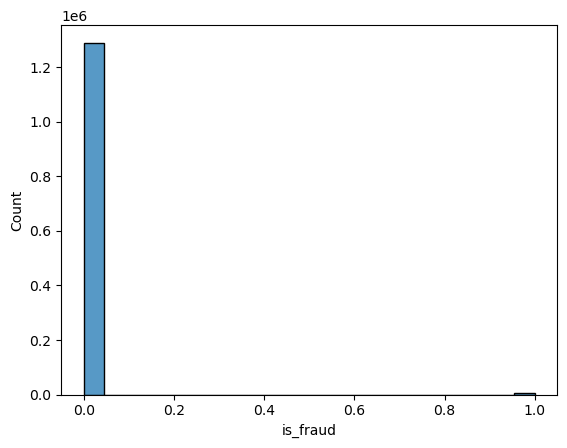

In [9]:
sb.histplot(card_details_train['is_fraud'])

In [10]:
# Splitting into dependent and independent feautres
X = card_details_train.iloc[:,:-1]
y = card_details_train.iloc[:,-1]

In [11]:
X, y = SMOTE().fit_resample(X, y)

### Training model

In [12]:
classifier = {"rf_classifier" : RandomForestClassifier(), "regressor" : LogisticRegression(), "tree":DecisionTreeClassifier(random_state=40)}

In [13]:
classifier["rf_classifier"].fit(X,y)
classifier["regressor"].fit(X,y)
classifier["tree"].fit(X,y)

DecisionTreeClassifier(random_state=40)

In [14]:
card_details_test = pd.read_csv('fraudTest.csv', index_col=0)

In [15]:
card_details_test = preprocess_data(card_details_test, 1, encoder)

In [16]:
X1 = card_details_test.iloc[:, :-1]
y1 = card_details_test.iloc[:, -1]

### Prediction

In [17]:
y_pred_rf = classifier["rf_classifier"].predict(X1)
y_pred_reg = classifier["regressor"].predict(X1)
y_pred_tree = classifier["tree"].predict(X1)

In [18]:
score_rf = accuracy_score(y1, y_pred_rf)
score_reg = accuracy_score(y1, y_pred_reg)
score_tree = accuracy_score(y1, y_pred_tree)

In [19]:
print(f"Score for Random Forest Classifier = {score_rf}\nScore for Logistic Regression classifier = {score_reg}\nScore for Decision Tree = {score_tree}")

Score for Random Forest Classifier = 0.9962624995726257
Score for Logistic Regression classifier = 0.9240893329182555
Score for Decision Tree = 0.9955697033932617


Classification report for best classifier

In [20]:
print(classification_report(y1, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.51      0.55      0.53      2145

    accuracy                           1.00    555719
   macro avg       0.76      0.78      0.77    555719
weighted avg       1.00      1.00      1.00    555719



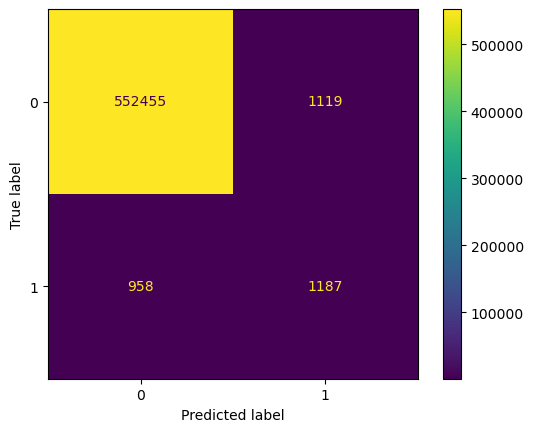

In [21]:
disp = ConfusionMatrixDisplay.from_estimator(classifier["rf_classifier"], X1, y1)

In [22]:
# Saving random forest model
with open('D:/Programming/rf_model.pkl', 'wb') as f:
    pickle.dump(classifier["rf_classifier"], f)

In [24]:
# Saving target encoder model
with open('D:/Programming/encoder_model.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [25]:
with open('D:/Programming/metadata.json', 'r') as f:
    meta = json.load(f)

In [26]:
meta

{'category': ['misc_net',
  'grocery_pos',
  'entertainment',
  'gas_transport',
  'misc_pos',
  'grocery_net',
  'shopping_net',
  'shopping_pos',
  'food_dining',
  'personal_care',
  'health_fitness',
  'travel',
  'kids_pets',
  'home'],
 'job': ['Psychologist, counselling',
  'Special educational needs teacher',
  'Nature conservation officer',
  'Patent attorney',
  'Dance movement psychotherapist',
  'Transport planner',
  'Arboriculturist',
  'Designer, multimedia',
  'Public affairs consultant',
  'Pathologist',
  'IT trainer',
  'Systems developer',
  'Engineer, land',
  'Systems analyst',
  'Naval architect',
  'Radiographer, diagnostic',
  'Programme researcher, broadcasting/film/video',
  'Energy engineer',
  'Event organiser',
  'Operational researcher',
  'Market researcher',
  'Probation officer',
  'Leisure centre manager',
  'Corporate investment banker',
  'Therapist, occupational',
  'Call centre manager',
  'Police officer',
  'Education officer, museum',
  'Physio